## Ship dwell time with RandomForest

In Linear Regression notebook we saw only very modest performance of our model. Load modules and data and quick sanity check

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

Load the data 

In [2]:
df_dwell = pd.read_csv('/work/data/cleansed/vessel_dwell_time.csv')

In [3]:
df_dwell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   imo                               1634 non-null   object 
 1   vessel_name                       1634 non-null   object 
 2   time_seen                         1634 non-null   object 
 3   target_terminal                   1634 non-null   object 
 4   avg_dwell_at_target_terminal      1634 non-null   float64
 5   num_of_vessel_at_target_terminal  1634 non-null   float64
 6   num_of_vessel_in_port             1634 non-null   float64
 7   weekday                           1634 non-null   int64  
 8   hour_of_day                       1634 non-null   int64  
 9   is_holiday                        1634 non-null   bool   
 10  vessel_operator                   1634 non-null   object 
 11  vessel_type                       1634 non-null   object 
 12  vessel

Quick review of our dwell time target variable shows it is heavily right skewed.

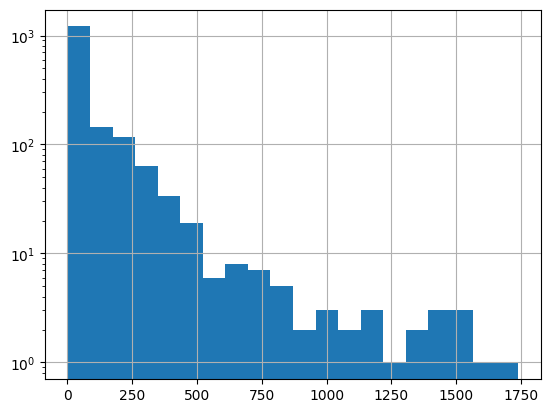

In [4]:
df = df_dwell.copy()
df.dwell_in_hr.hist(bins=20, log=True);

## Build RandomForest models

Try to build basic model. In our linear regression model earlier a couple of the preprocessing steps were:

*   Scale the training data
*   One hot encoded categorical columns

However unlike Linear Regression and some other supervised learning methods, in RandomForest, in theory, we don't need to perform those. So building the model is straightforward.

However some of our categorical data is of string type. So we will still do one hot encoding to avoid runtime error from the "fit()" function.

We'll follow the usual steps to split the data, then build the model.

In [5]:
"""
Helper function to get data in a specific format. Data is already cleaned.

  Parameters:
    df: dataframe, this is the data source
    features: list of column names that are the features plus the target also
    target: str, the target variable column name
    ohe: bool, to do one hot encoding or not

  Output:
    X_train, X_test, y_train, y_test
"""
def get_data(df, features, target, ohe=False):
    X = df[features].copy()
    if ohe:
        X = pd.get_dummies(data=X)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    print(X.shape,y.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

"""
Helper function to calculate MAE and s.d.
"""
def mean_abs_err_std(y_test_arr, pred):
    err = (y_test_arr - pred)
    mae = np.mean(np.abs(err))
    std = np.std(err)
    return mae, std

"""
Helper function to print out model score and error statistics

"""
def print_scores_errors(regr, X_train, X_test, y_train, y_test, pred):
    print('Ship dwell time accuracy\n')
    print('Accuracy of RF regressor on training set: {:.3f}'
        .format(regr.score(X_train, y_train)))
    print('Accuracy of RF regressor on test set: {:.3f}\n'
        .format(regr.score(X_test, y_test)))
    print('MSE: {:.3f}'.format(mean_squared_error(y_test, pred)))
    print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, pred))))
    print('MAE: {:.3f} ± {:.3f}'.format(
        mean_absolute_error(y_test, pred),
        mean_abs_err_std(y_test.values, pred)[1]))
    print('MAPE: {:.3f}'.format(mean_absolute_percentage_error(y_test, pred)))
    print('MedianAE: {:.3f}'.format(median_absolute_error(y_test, pred)))

"""
Helper function get a sorted dataframe of feature_importances_

"""
def get_feature_importance_df(clf, features):
  importance = list(zip(features, clf.feature_importances_))
  importance.sort(key=lambda x: x[1], reverse=True)
  return pd.DataFrame(importance, columns=['feature', 'importance']).round(3)

"""
Helper function adapted from SIADS542 shared utilities

  Plots the "feature_importances_" vertically, from the model, using df
"""
def plot_feature_importances_df(df, figsize):
  ax = df.plot(kind='bar', title ="Feature Importance", figsize=figsize)
  plt.xlabel("Feature name")
  plt.xticks(np.arange(len(df['feature'])), df['feature'].values, rotation=45, ha='right')
  plt.ylabel("Feature importance")
  plt.show()


### RandomForest with numerical features only.

Get just the numeric columns and train test split it.

In [6]:
features = ['avg_dwell_at_target_terminal', 'num_of_vessel_at_target_terminal',
            'num_of_vessel_in_port','weekday','hour_of_day','is_holiday',
            'vessel_width','vessel_length','vessel_dwt']
target = 'dwell_in_hr'

X_train, X_test, y_train, y_test = get_data(df, features, target, ohe=False)

(1634, 9) (1634,) (1225, 9) (409, 9) (1225,) (409,)


Create a RandomForestRegressor model with default parameters, fit it, then make predictions on test data and print out score and some error statistic. MAE is what we're interested in.

In [7]:
regr = RandomForestRegressor(random_state = 42)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print_scores_errors(regr, X_train, X_test, y_train, y_test, pred)

Ship dwell time accuracy

Accuracy of RF regressor on training set: 0.909
Accuracy of RF regressor on test set: 0.437

MSE: 23916.876
RMSE: 154.651
MAE: 69.448 ± 154.650
MAPE: 1.930
MedianAE: 23.227


A test score of 0.437 is quite low, considering training score was 0.909. This could be a sign of overfitting. MAE score is 69.448. Let's see what the model thought was the most important feature. We do this using the **feature_importances_** variable.

In [8]:
df_importance_num = get_feature_importance_df(regr, features)
df_importance_num

,feature,importance
0,avg_dwell_at_target_terminal,0.402
1,num_of_vessel_in_port,0.244
2,vessel_dwt,0.118
3,hour_of_day,0.070
4,vessel_length,0.069
5,vessel_width,0.035
6,weekday,0.031
7,num_of_vessel_at_target_terminal,0.030
8,is_holiday,0.000


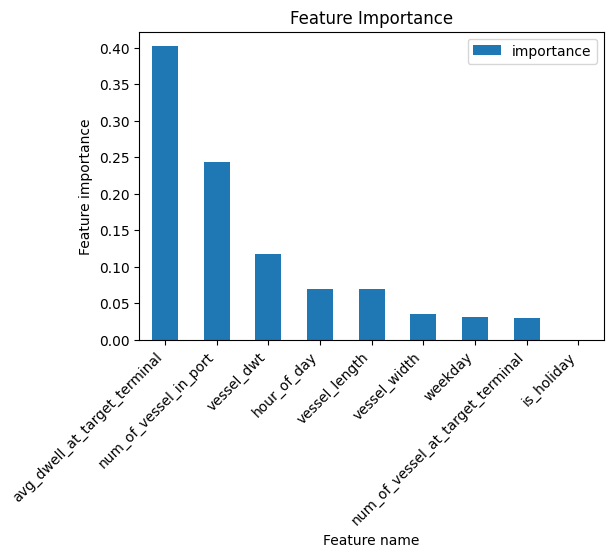

In [9]:
plot_feature_importances_df(df_importance_num, figsize=(6,4))

### RandomForest with numeric and categorical features.

This time we'll numeric and categorical columns and train test split it as well as do one hot encoding on the categorical data. 

Here we decided that **IMO**, **Vessel Name**, **Timeseen**, and **vessel_type** serve as record identifies for result analysis later so we will exclude them.

In [10]:
features = ['target_terminal', 'avg_dwell_at_target_terminal',
            'num_of_vessel_at_target_terminal', 'num_of_vessel_in_port',
            'weekday', 'hour_of_day', 'is_holiday', 
            'vessel_operator', 'vessel_width', 'vessel_length', 'vessel_dwt']
target = 'dwell_in_hr'

X_train, X_test, y_train, y_test = get_data(df, features, target, ohe=True)

# Because we set ohe=True, we have expanded features from one hot encoding
features = X_train.columns

(1634, 51) (1634,) (1225, 51) (409, 51) (1225,) (409,)


In [11]:
regr = RandomForestRegressor(random_state = 42)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print_scores_errors(regr, X_train, X_test, y_train, y_test, pred)

Ship dwell time accuracy

Accuracy of RF regressor on training set: 0.919
Accuracy of RF regressor on test set: 0.530

MSE: 19983.962
RMSE: 141.365
MAE: 62.557 ± 141.328
MAPE: 1.644
MedianAE: 20.008


In [12]:
df_importance_numcat = get_feature_importance_df(regr, features)
df_importance_numcat

,feature,importance
0,avg_dwell_at_target_terminal,0.341
1,num_of_vessel_in_port,0.213
2,vessel_dwt,0.083
3,vessel_operator_WAN HAI,0.070
4,hour_of_day,0.051
5,vessel_length,0.043
6,num_of_vessel_at_target_terminal,0.040
7,weekday,0.022
8,vessel_operator_SEA LEAD SHIPPING PTE LTD,0.022
9,target_terminal_PierJ,0.021


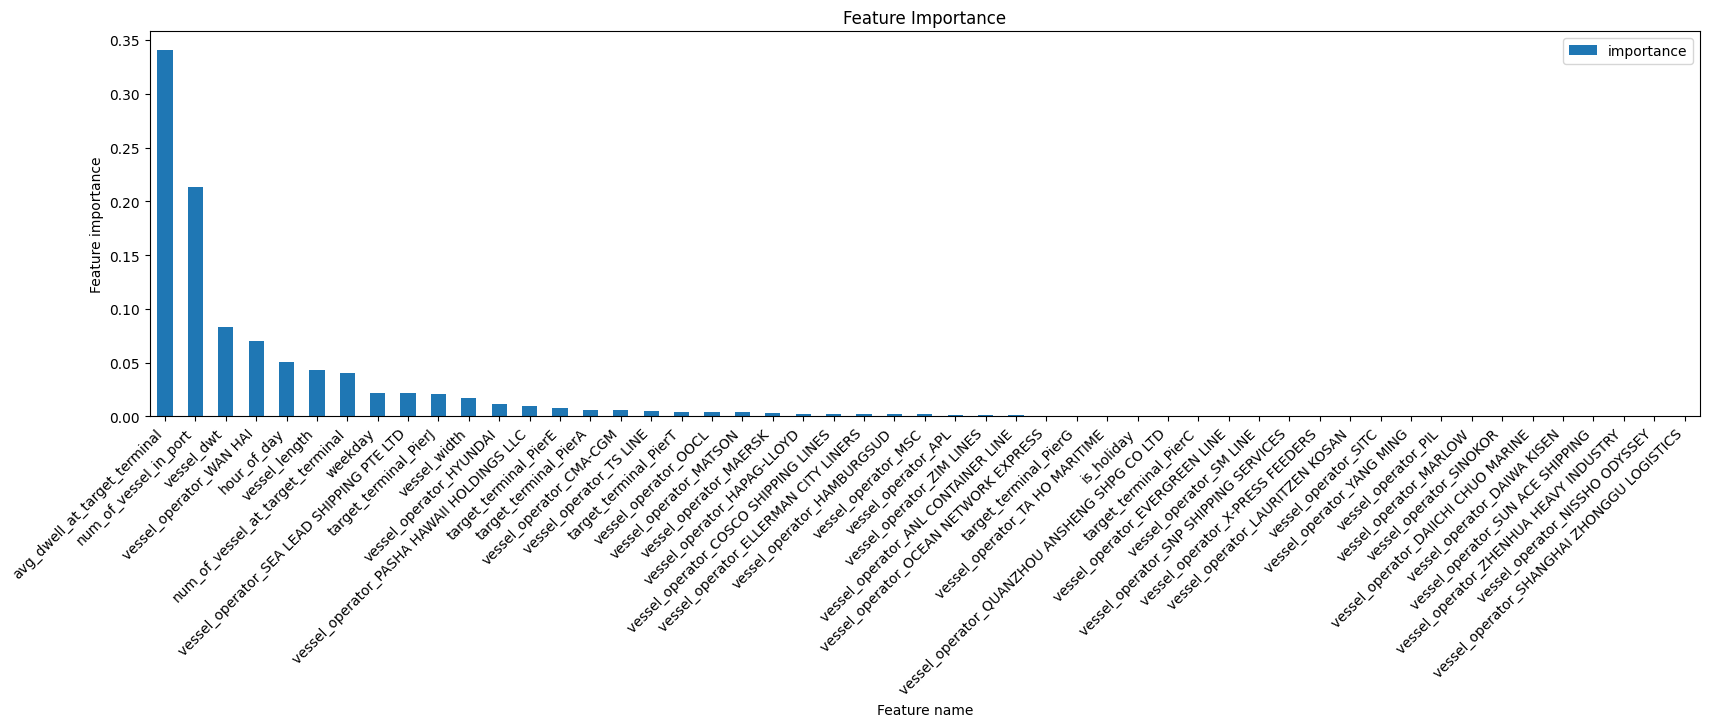

In [13]:
plot_feature_importances_df(df_importance_numcat, figsize=(20,5))

Comparing the model scores with only numeric features vs numeric and categorical features showed only a small impovement:

*   training set: 0.909 -> 0.919
*   test set: 0.437 -> 0.530
*   MAE: 69.448 -> 62.557

The majority of the features seem to have zero effect on the dwell time. The top 10 features with numeric values only vs numeric/categorical did not change much. Although a couple of the categorical features displaced some numeric features:


In [14]:
print('Numeric Features Only\n\n',df_importance_num[:10])

Numeric Features Only

                             feature  importance
0      avg_dwell_at_target_terminal       0.402
1             num_of_vessel_in_port       0.244
2                        vessel_dwt       0.118
3                       hour_of_day       0.070
4                     vessel_length       0.069
5                      vessel_width       0.035
6                           weekday       0.031
7  num_of_vessel_at_target_terminal       0.030
8                        is_holiday       0.000


In [15]:
print('Numeric and Categorical Features\n\n',df_importance_numcat[:10])

Numeric and Categorical Features

                                      feature  importance
0               avg_dwell_at_target_terminal       0.341
1                      num_of_vessel_in_port       0.213
2                                 vessel_dwt       0.083
3                    vessel_operator_WAN HAI       0.070
4                                hour_of_day       0.051
5                              vessel_length       0.043
6           num_of_vessel_at_target_terminal       0.040
7                                    weekday       0.022
8  vessel_operator_SEA LEAD SHIPPING PTE LTD       0.022
9                      target_terminal_PierJ       0.021


The next step is to try hyperparameter tuning for the model.

### RandomForest with numeric and categorical features, with hyperparameter tuning and cross validation

First let's see what the default settings are for RandomForestRegressor

In [16]:
RandomForestRegressor(random_state = 42).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Ok we see **n_estimators** is set to 100 by default. In class we learned that the default was **10** at the time and it was mentioned that was a good value. We also learned that the default values for the other two other major parameters **max_features** and **max_depth** seem to work well in practice, so we will leave them alone for now just to see what happens. 


In [17]:
regr = RandomForestRegressor(n_estimators=10, random_state = 42)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print_scores_errors(regr, X_train, X_test, y_train, y_test, pred)
print('\n\nNumeric/Categorical with 10 estimators\n\n',get_feature_importance_df(regr, features)[:10])

Ship dwell time accuracy

Accuracy of RF regressor on training set: 0.903
Accuracy of RF regressor on test set: 0.508

MSE: 20893.236
RMSE: 144.545
MAE: 64.325 ± 144.525
MAPE: 1.722
MedianAE: 17.930


Numeric/Categorical with 10 estimators

                                      feature  importance
0               avg_dwell_at_target_terminal       0.330
1                      num_of_vessel_in_port       0.199
2                                 vessel_dwt       0.071
3                    vessel_operator_WAN HAI       0.068
4                              vessel_length       0.051
5           num_of_vessel_at_target_terminal       0.051
6                                hour_of_day       0.050
7  vessel_operator_SEA LEAD SHIPPING PTE LTD       0.029
8                                    weekday       0.027
9                      target_terminal_PierJ       0.024


Ok at first glance, n_estimators = 10 actually made all scores a little worse. Next try GridSearch and Cross Validation

#### GridSearch and Cross Validation

In [18]:
# We randomly searched and found these parameters were best. So we'll gridsearch closer 
# to these to save time and effort hoping it can do better than random.
#
# {'n_estimators': 400,
#  'min_samples_split': 10,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 60,
#  'bootstrap': False}

# Try a variety of values.
param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 60, 80, None],
    'max_features': [2, 10, 'sqrt'],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 400, 600, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 10, n_jobs = -1, verbose = 10)


In [19]:
%%time

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

[CV 2/10; 527/576] END bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600;, score=0.556 total time=   0.7s
[CV 3/10; 527/576] START bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600
[CV 3/10; 527/576] END bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600;, score=0.688 total time=   0.8s
[CV 4/10; 527/576] START bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600
[CV 4/10; 527/576] END bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600;, score=0.323 total time=   0.8s
[CV 5/10; 527/576] START bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min_samples_split=12, n_estimators=600
[CV 5/10; 527/576] END bootstrap=False, max_depth=None, max_features=10, min_samples_leaf=10, min

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 100}

In [20]:
best_grid = grid_search.best_estimator_
best_grid.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 60,
 'max_features': 10,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
pred = best_grid.predict(X_test)
print_scores_errors(best_grid, X_train, X_test, y_train, y_test, pred)
print('\n\nNumeric/Categorical with best GridSearchCV RF\n\n',get_feature_importance_df(best_grid, features)[:10])

Ship dwell time accuracy

Accuracy of RF regressor on training set: 0.804
Accuracy of RF regressor on test set: 0.521

MSE: 20366.520
RMSE: 142.711
MAE: 62.482 ± 142.581
MAPE: 1.575
MedianAE: 21.544


Numeric/Categorical with best GridSearchCV RF

                             feature  importance
0      avg_dwell_at_target_terminal       0.293
1             num_of_vessel_in_port       0.249
2                        vessel_dwt       0.068
3           vessel_operator_WAN HAI       0.059
4                     vessel_length       0.059
5  num_of_vessel_at_target_terminal       0.041
6                       hour_of_day       0.036
7                      vessel_width       0.031
8             target_terminal_PierE       0.026
9             target_terminal_PierJ       0.023


So after the most thorough run of RandomForest we see these results:

* training set accuracy: 0.804
* test set accuracy: 0.521
* MAE 62.482 ± 142.581

A test set score of 0.521 is just too low. This could be an indication of overfitting. But as we saw in the Linear Regression notebook, there was just not much correlations between the variables. Interestingly the feature that are the most important continues to be by far:

* avg_dwell_at_target_terminal: 0.293 (all time high was 0.40)
* num_of_vessel_in_port: 0.249: (all time high was 0.24)
* vessel_dwt: 0.068: (all time high was 0.12)

The other features drop dramatically in importance:

* vessel_operator_WAN HAI: 0.059
* vessel_length: 0.059
* num_of_vessel_at_target_terminal: 0.041
* hour_of_day: 0.036
* vessel_width: 0.031
* target_terminal_PierE: 0.026
* target_terminal_PierJ: 0.023
* ...


Next we will go to gradient boosting...CatBoost

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>